In [1]:
# import libraries -- copied from assignment

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC, SVC
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
# # read in data and print head

# df_manhattan = pd.read_csv('/content/drive/MyDrive/AML/Project/manhattan.csv')
# df_manhattan.head()

In [3]:
# read in data and print head

df_manhattan = pd.read_csv('../data/manhattan.csv')
df_manhattan.head()

,rental_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood,borough
0,1545,2550,0.0,1,480,9,2.0,17,1,1,0,0,1,1,0,1,Upper East Side,Manhattan
1,2472,11500,2.0,2,2000,4,1.0,96,0,0,0,0,0,0,0,0,Greenwich Village,Manhattan
2,2919,4500,1.0,1,916,2,51.0,29,0,1,0,1,1,1,0,0,Midtown,Manhattan
3,2790,4795,1.0,1,975,3,8.0,31,0,0,0,1,1,1,0,1,Greenwich Village,Manhattan
4,3946,17500,2.0,2,4800,3,4.0,136,0,0,0,1,1,1,0,1,Soho,Manhattan


In [4]:
# check length of data and number of features (excluding target)

shape = df_manhattan.shape

print('There are', shape[0], 'data rows and ', shape[1] -1 , 'features in the dataset')

There are 3539 data rows and  17 features in the dataset


## __Initial Data Exploration:__

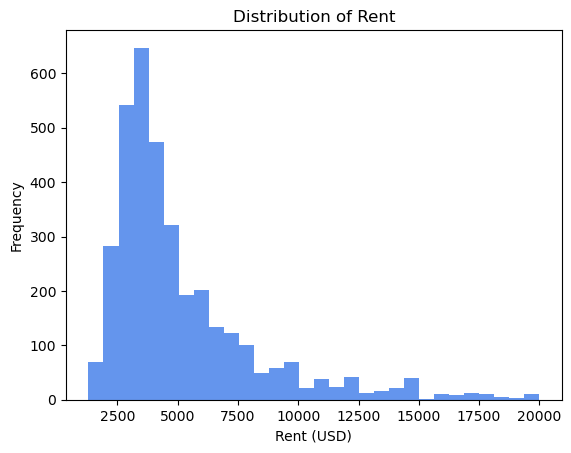

In [6]:
# Check balance of target variable

df_manhattan['rent'].hist(bins=30, color='cornflowerblue')
plt.xlabel('Rent (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Rent')
plt.grid(False)
plt.show()

From the plot above, it is clear that there are far more rentals that are less than $10,000$ per month. To ensure that this imbalance is reflected in our data split, we can calculate the fraction of data above and below $10,000. From lecture 3, we were also shown that we can take the log of the data. This is shown below:

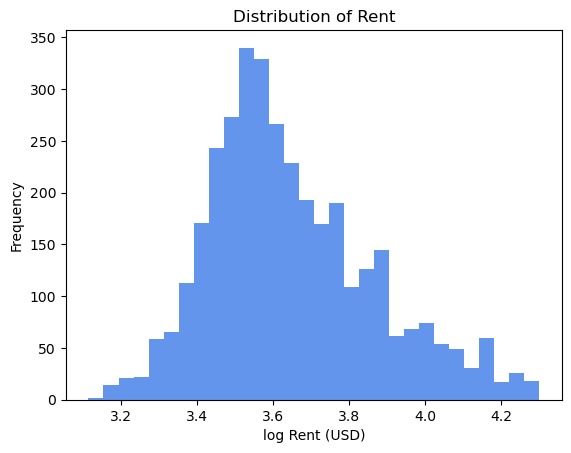

In [8]:
# Also plot distribution of rent with a logarithmic scale

np.log10(df_manhattan['rent']).hist(bins=30, color='cornflowerblue')
plt.xlabel('log Rent (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Rent')
plt.grid(False)
plt.show()

The distribution of rental prices is fairly symmetric after taking the log (base 10). Instead of stratifying as suggested above, we will proceed in our analysis with the log of the rental price.

## __Clean Data:__

In [11]:
# Find missing values -- isnull() finds None or nan

missing_values = df_manhattan.isnull().sum()
missing_values

rental_id           0
rent                0
bedrooms            0
bathrooms           0
size_sqft           0
min_to_subway       0
floor               0
building_age_yrs    0
no_fee              0
has_roofdeck        0
has_washer_dryer    0
has_doorman         0
has_elevator        0
has_dishwasher      0
has_patio           0
has_gym             0
neighborhood        0
borough             0
dtype: int64

There are no missing values.

In [13]:
# Set target and drop the rental_id feature, since it is not needed for the model
# Also drop the borough feature, since it is only Manhattan

X = df_manhattan.drop(['rent', 'rental_id', 'borough'], axis=1)
y = df_manhattan['rent']

In [14]:
# Separate data into development and test sets
# Non-stratified split, 80 percent development, 20 percent test

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80-20 split

In [15]:
X_dev_gs = X_dev.copy()

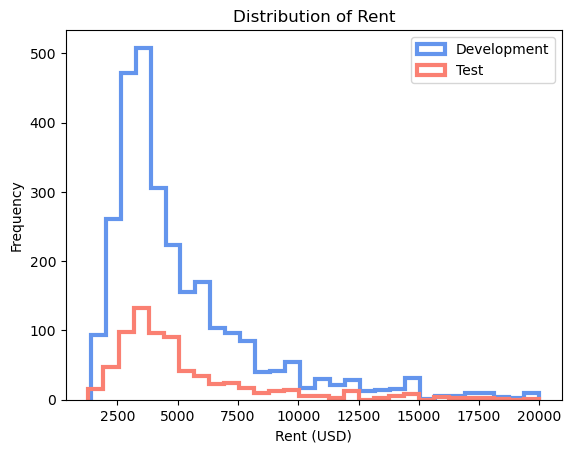

In [16]:
# plot distribition of target variable in development set and test set with no log scaling

y_dev.hist(bins=30, color='cornflowerblue', histtype='step', lw=3, label='Development')
y_test.hist(bins=30, color='salmon', histtype='step', lw=3, label='Test')
plt.xlabel('Rent (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Rent')
plt.grid(False)
plt.legend()
plt.show()

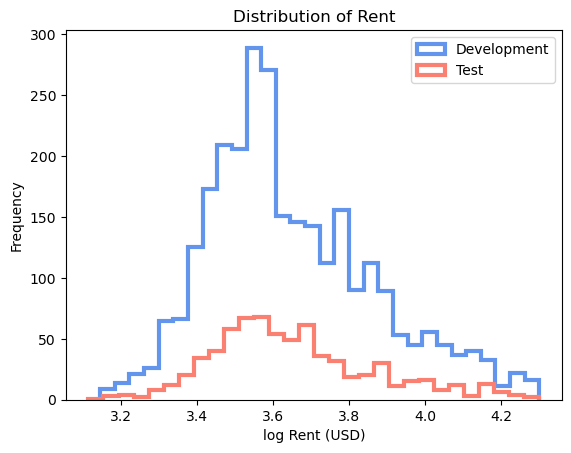

In [17]:
# plot distribition of target variable in development set and test set with log scaling

np.log10(y_dev).hist(bins=30, color='cornflowerblue', histtype='step', lw=3,label='Development')
np.log10(y_test).hist(bins=30, color='salmon', histtype='step', lw=3,label='Test')
plt.xlabel('log Rent (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Rent')
plt.grid(False)
plt.legend()
plt.show()

From the figures above, it seems that the non-stratified data split is able to capture the the distribution well, even at the high rental price end. 

In [19]:
# Encode categorical features -- just neighborhood

# List categorical (both hot encoding and label encoding) and numerical features
cat_features_hot = ["neighborhood"]

# encode using One Hot Encoder, since there is no ordering or ranking of neighborhoods
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="error"), cat_features_hot),remainder="passthrough")

transformed_data = preprocess.fit_transform(X_dev)
feature_names = preprocess.get_feature_names_out()

# Convert back to pandas data frame
X_dev_encoded = pd.DataFrame(transformed_data, columns=feature_names)

# Encode the test datsets and transform to pandas data frame
X_test_encoded = pd.DataFrame(preprocess.transform(X_test), columns=feature_names)


In [20]:
# print to make sure worked correctly

X_dev_encoded.head()

,onehotencoder__neighborhood_Battery Park City,onehotencoder__neighborhood_Central Harlem,onehotencoder__neighborhood_Central Park South,onehotencoder__neighborhood_Chelsea,onehotencoder__neighborhood_Chinatown,onehotencoder__neighborhood_East Harlem,onehotencoder__neighborhood_East Village,onehotencoder__neighborhood_Financial District,onehotencoder__neighborhood_Flatiron,onehotencoder__neighborhood_Gramercy Park,...,remainder__floor,remainder__building_age_yrs,remainder__no_fee,remainder__has_roofdeck,remainder__has_washer_dryer,remainder__has_doorman,remainder__has_elevator,remainder__has_dishwasher,remainder__has_patio,remainder__has_gym
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,10.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,57.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# fit a standard scaler to the training data, apply this standard scaler to the validation/test data

ss = StandardScaler()

X_dev_scaled = pd.DataFrame(ss.fit_transform(X_dev_encoded), columns=feature_names)
X_test_scaled = pd.DataFrame(ss.transform(X_test_encoded), columns=feature_names)

# Note, we also put back into pandas data frame -- will ensure we keep feature names when we print out feature importance later

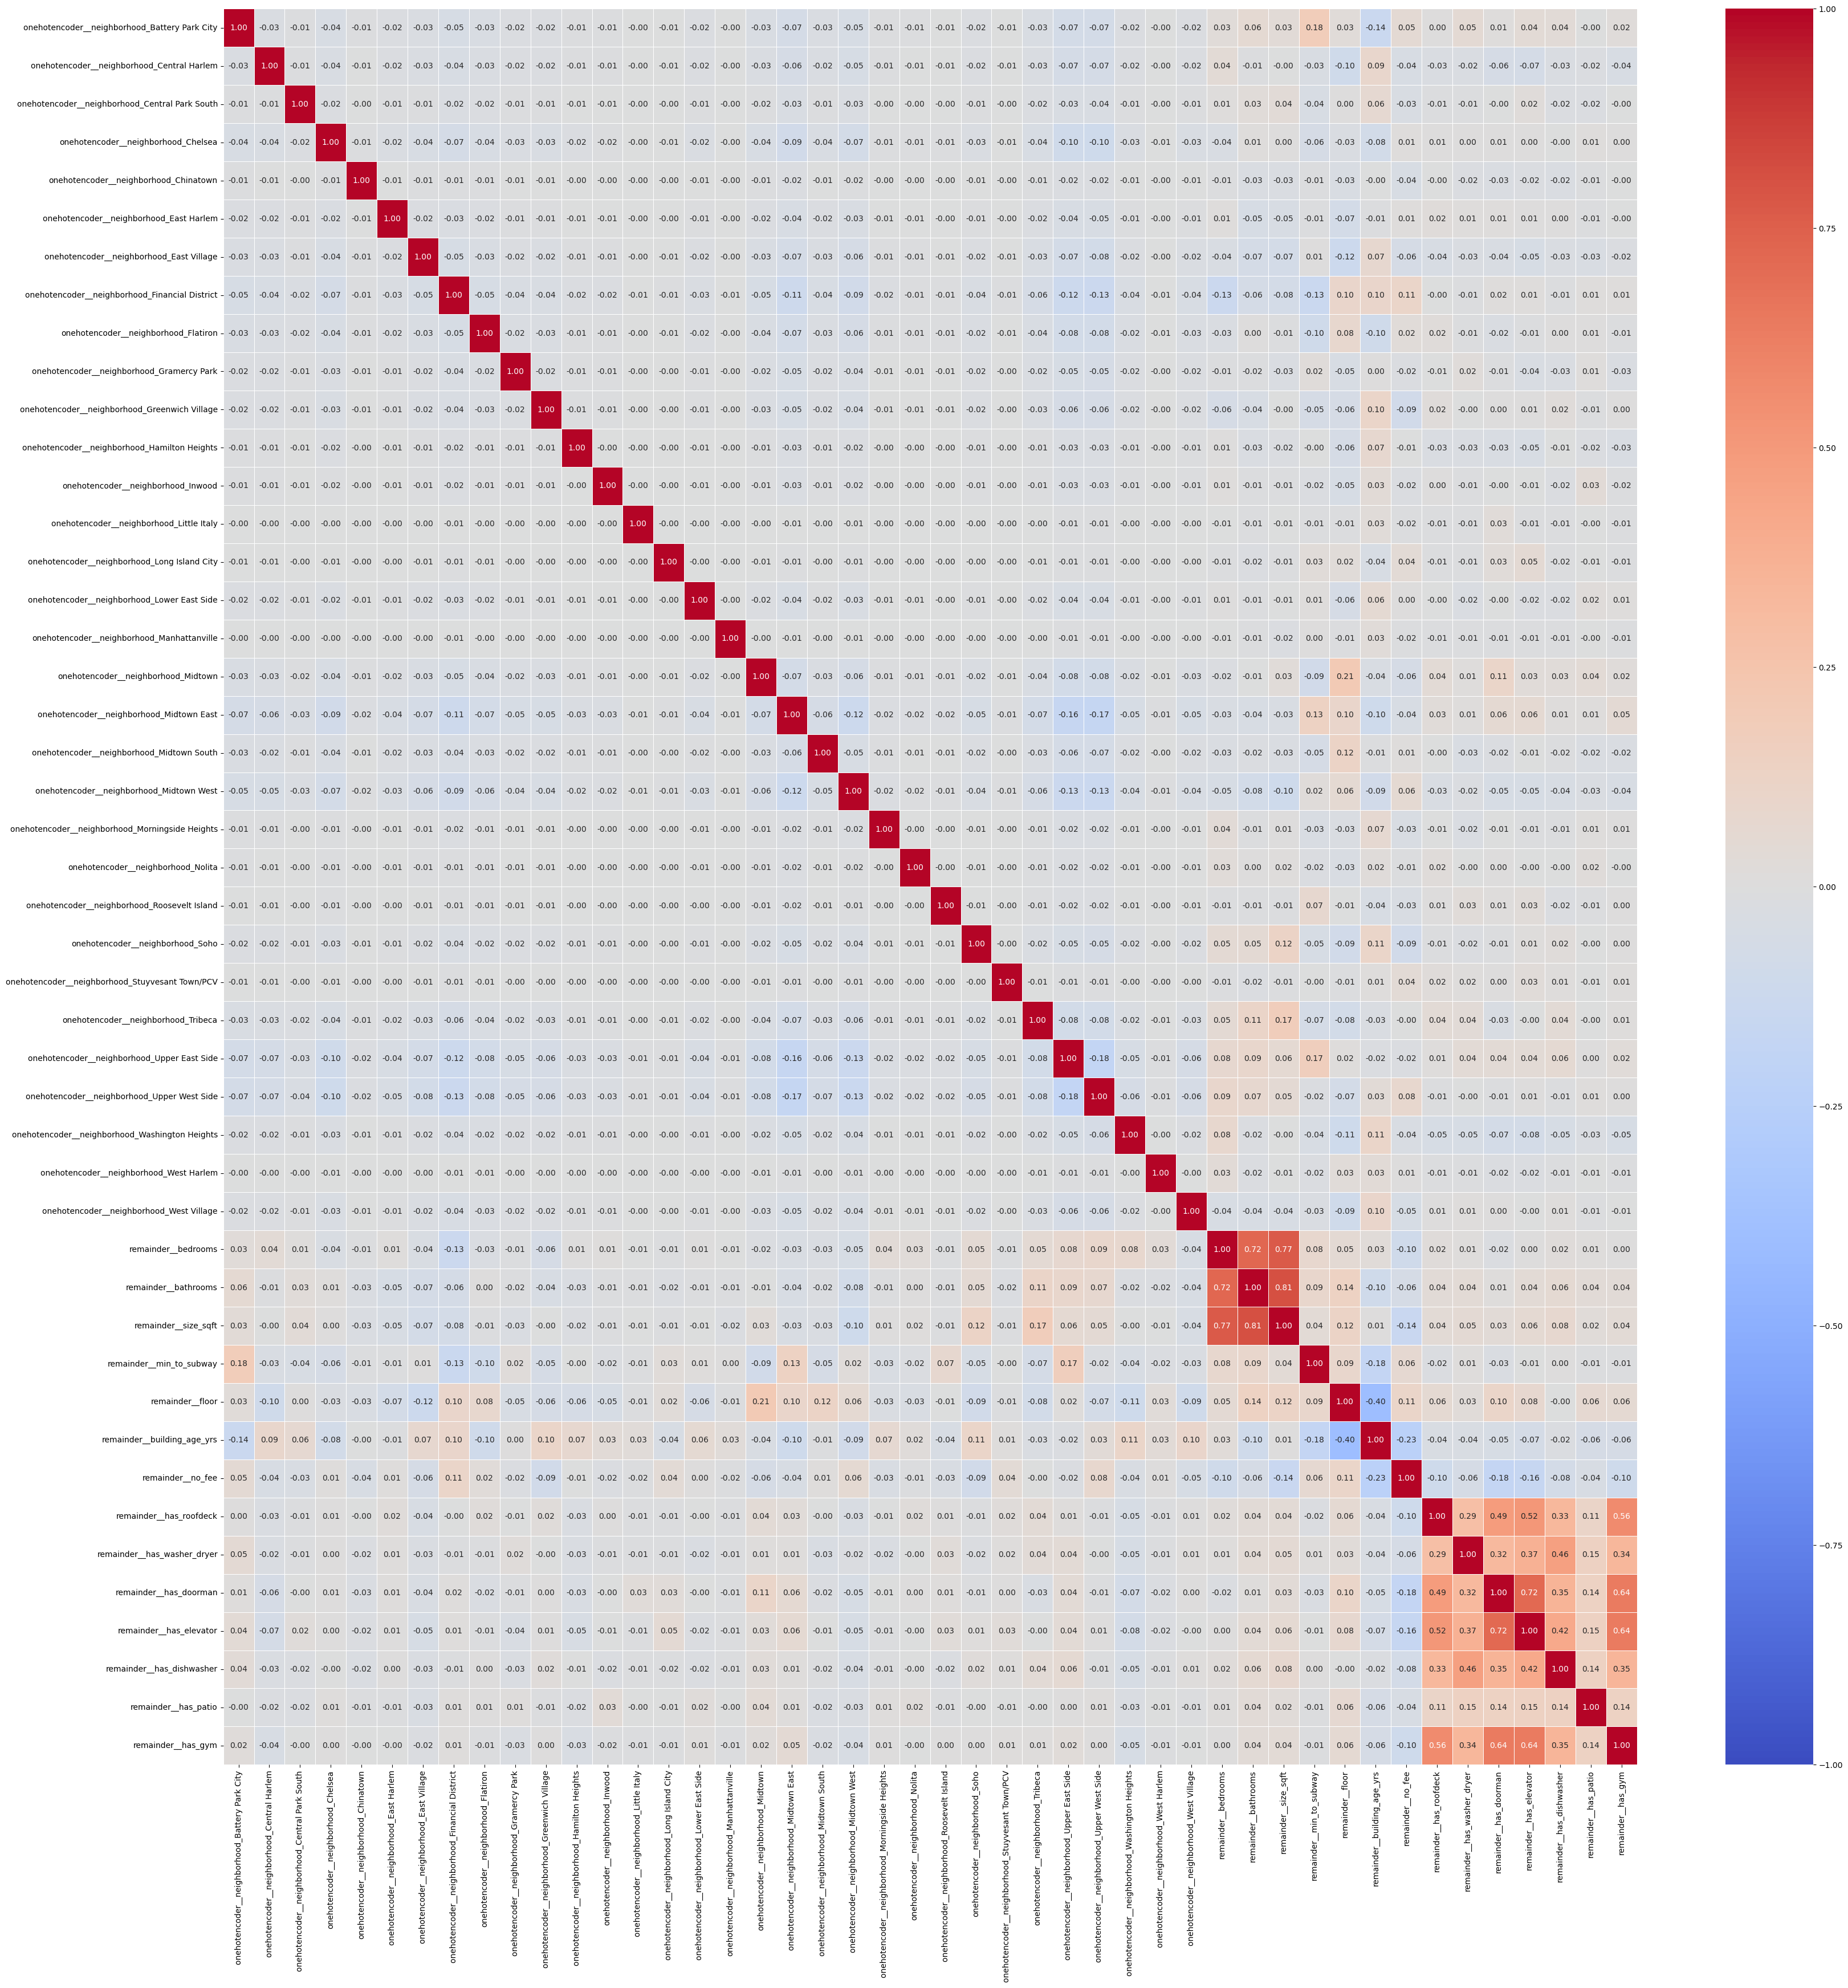

In [22]:
# Compute correlation matrix for development data

corr_matrix = X_dev_encoded.corr()

# Plot correlation matrix
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.show()

There are 0.70-0.80 correlations between square footage, number of bedrooms, and number of bathrooms. This makes sense, since a larger apartment will be able to accomodate more rooms, whether bedrooms or bathrooms. We will keep these in the dataset, since this may only affect a linear model, not decsions trees or other methods we propose using.

## __Insights from Data Exploration:__

/var/folders/h5/6c2y_1y93z7bx9kg49xs9vnm0000gn/T/ipykernel_17766/991287962.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_rent = dev_data.groupby(['subway_bin'])['rent'].mean().reset_index()


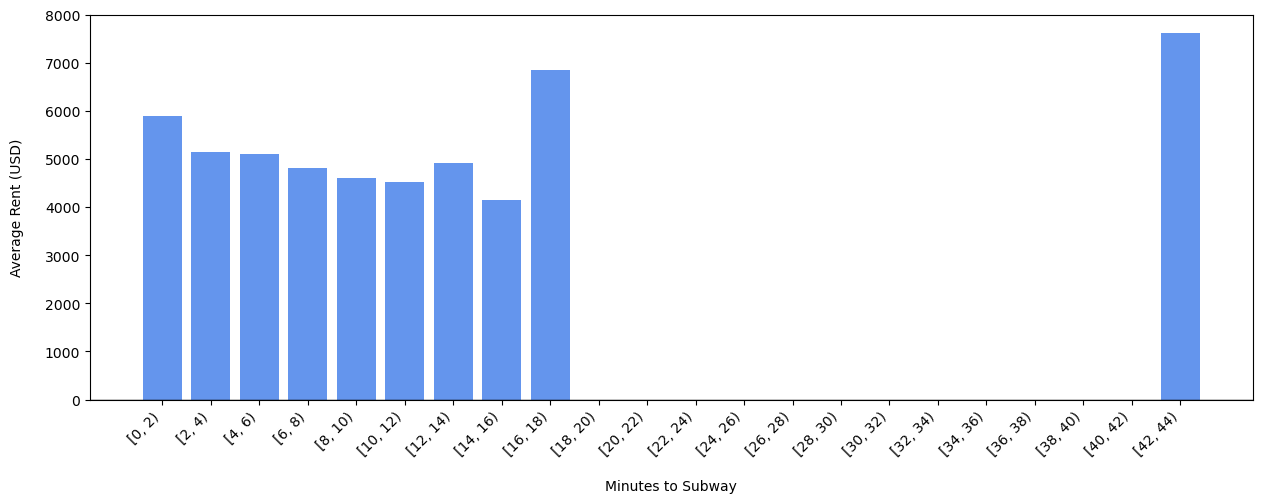

In [25]:
# First, look at subway time and average rent, binning subway time into 2-minute intervals

# Bin 'min_to_subway' into 2-minute intervals
dt = 2  # binning interval
subway_bins = np.arange(0, X_dev['min_to_subway'].max() + dt, dt)
X_dev['subway_bin'] = pd.cut(X_dev['min_to_subway'], bins=subway_bins, right=False)

# Combine X_dev and y_dev into a single DataFrame for grouping
dev_data = X_dev.copy()
dev_data['rent'] = y_dev

# Calculate mean rent for each subway time bin
avg_rent = dev_data.groupby(['subway_bin'])['rent'].mean().reset_index()

# Set labels for subway time bins
labels = [f"{row.subway_bin}" for row in avg_rent.itertuples(index=False)]

# Create the plot
plt.figure(figsize=(15, 5))
plt.bar(avg_rent.index, avg_rent['rent'], color="cornflowerblue")  # Use default index
plt.axhline(0, color="black", linewidth=1)

plt.xlabel("Minutes to Subway", labelpad=15)
plt.ylabel("Average Rent (USD)", labelpad=15)
plt.xticks(ticks=avg_rent.index, labels=labels, rotation=45, ha='right')

plt.show()


/var/folders/h5/6c2y_1y93z7bx9kg49xs9vnm0000gn/T/ipykernel_17766/2907624353.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_rent = dev_data.groupby(['age_bins'])['rent'].mean().reset_index()


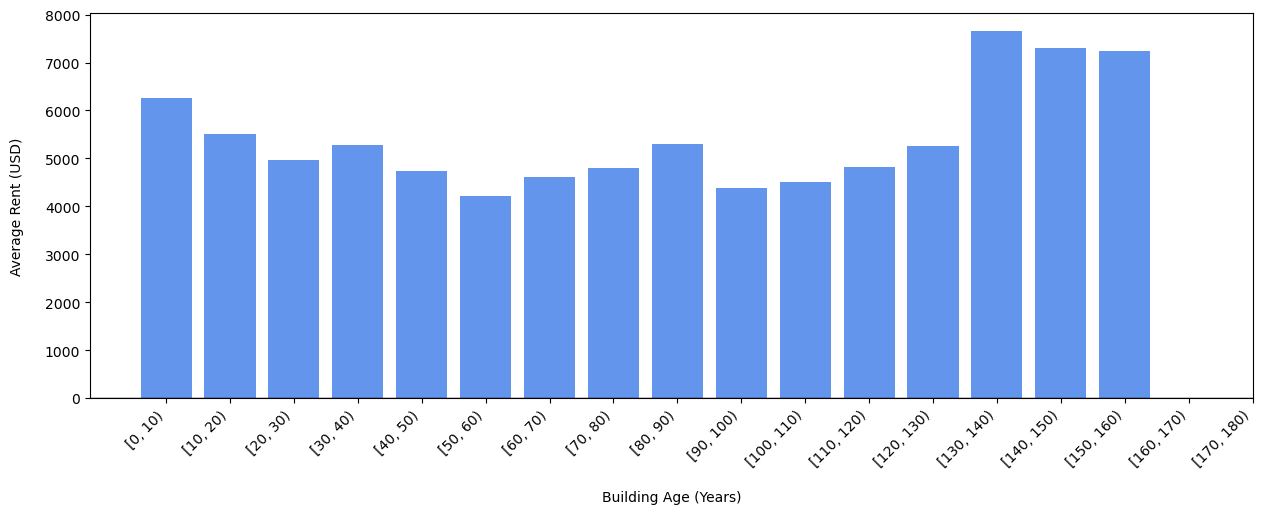

In [26]:
# Second, look at building age and average rent, binning age into 10-year intervals

# Bin 'building_age_yrs' into 10-year intervals
dt = 10  # binning interval
age_bins = np.arange(0, X_dev['building_age_yrs'].max() + dt, dt)
X_dev['age_bins'] = pd.cut(X_dev['building_age_yrs'], bins=age_bins, right=False)

# Combine X_dev and y_dev into a single DataFrame for grouping
dev_data = X_dev.copy()
dev_data['rent'] = y_dev

# Calculate mean rent for each building age bin
avg_rent = dev_data.groupby(['age_bins'])['rent'].mean().reset_index()

# Set labels for building age bins
labels = [f"{row.age_bins}" for row in avg_rent.itertuples(index=False)]

# Create the plot
plt.figure(figsize=(15, 5))
plt.bar(avg_rent.index, avg_rent['rent'], color="cornflowerblue")  # Use default index
plt.axhline(0, color="black", linewidth=1)

plt.xlabel("Building Age (Years)", labelpad=15)
plt.ylabel("Average Rent (USD)", labelpad=15)
plt.xticks(ticks=avg_rent.index, labels=labels, rotation=45, ha='right')

plt.show()

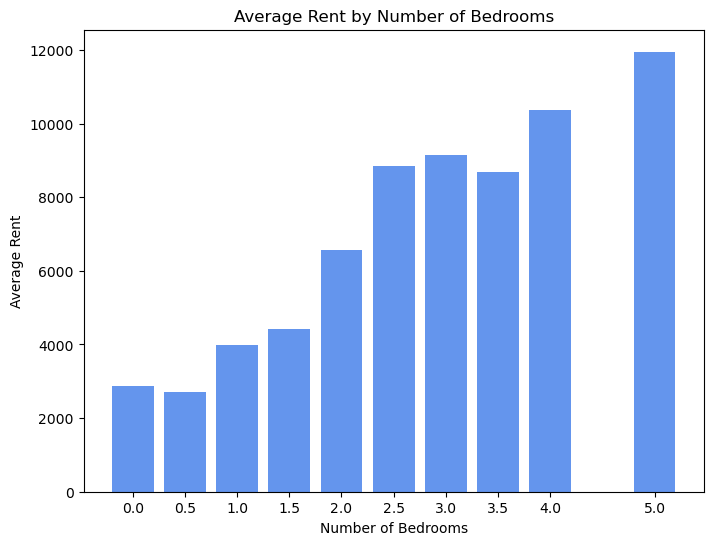

In [27]:
# Combine X and y into a single DataFrame along the columns.
df_dev = pd.concat([X_dev, y_dev], axis=1)

# Group by 'bedrooms' and calculate the mean y value for each group.
avg_y_by_bedrooms = df_dev.groupby("bedrooms")["rent"].mean()

# Plot the results
x_pos = avg_y_by_bedrooms.index.astype(float)

plt.figure(figsize=(8, 6))
plt.bar(x_pos, avg_y_by_bedrooms.values, width=0.4, align='center', color="cornflowerblue")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Average Rent")
plt.title("Average Rent by Number of Bedrooms")
plt.xticks(x_pos, avg_y_by_bedrooms.index)  # Use the actual bedroom numbers as labels
plt.show()

In [28]:
# As the number of bedrooms increase, the average rent increases.

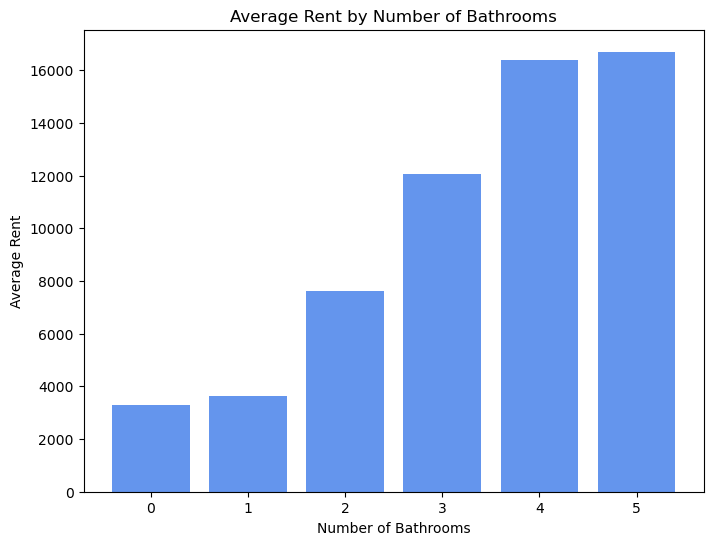

In [29]:
# Group by 'bathrooms' and calculate the mean y value for each group.
avg_y_by_bathrooms = df_dev.groupby("bathrooms")["rent"].mean()

# Plot the results
x_pos = avg_y_by_bathrooms.index.astype(float)

plt.figure(figsize=(8, 6))
plt.bar(x_pos, avg_y_by_bathrooms.values, width=0.8, align='center', color="cornflowerblue")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Average Rent")
plt.title("Average Rent by Number of Bathrooms")
plt.xticks(x_pos, avg_y_by_bathrooms.index)  # Use the actual bedroom numbers as labels
plt.show()

In [30]:
# As the number of bathrooms increase, the average rent increases.

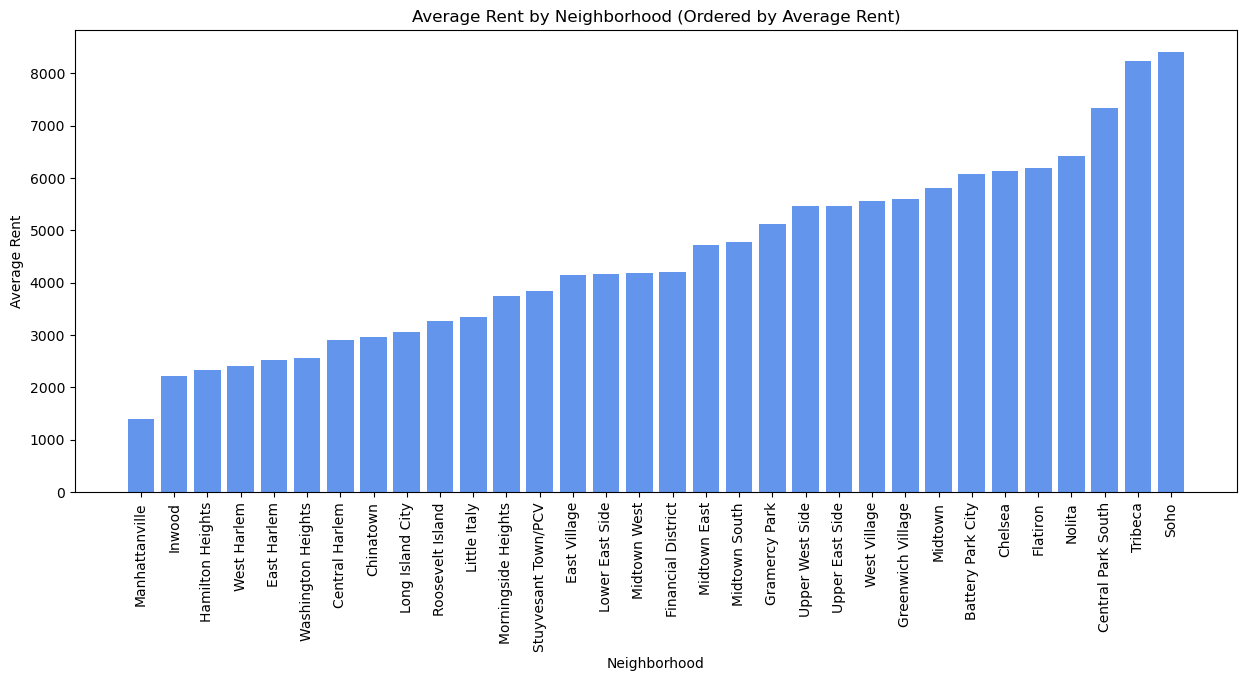

In [31]:
# Group by 'neighborhood' and calculate the mean rent for each group
avg_y_by_neighborhood = df_dev.groupby("neighborhood")["rent"].mean()

# Sort the series by the average rent values (ascending order)
avg_y_by_neighborhood = avg_y_by_neighborhood.sort_values()

# Use the sorted neighborhood values as x positions (assuming the neighborhoods are numeric)
x_pos = np.arange(len(avg_y_by_neighborhood))

# Plot the results as a bar plot
plt.figure(figsize=(15, 6))
plt.bar(x_pos, avg_y_by_neighborhood.values, width=0.8, align='center', color="cornflowerblue")
plt.xlabel("Neighborhood")
plt.ylabel("Average Rent")
plt.title("Average Rent by Neighborhood (Ordered by Average Rent)")
plt.xticks(x_pos, avg_y_by_neighborhood.index, rotation = 90)  # Set x-tick labels to the sorted neighborhood values
plt.show()

In [32]:
# Manhattanville has the lowest average rent, while Soho has the highest—over five times the average rent of Manhattanville.

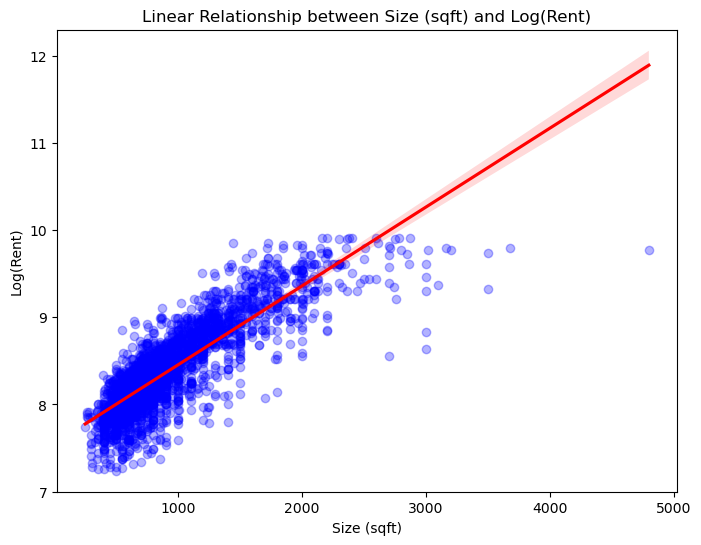

In [33]:
plt.figure(figsize=(8, 6))
sns.regplot(x=df_dev['size_sqft'], y=np.log(df_dev['rent']), scatter_kws={'color': 'blue', 'alpha': 0.3}, line_kws={'color': 'red'})
plt.xlabel('Size (sqft)')
plt.ylabel('Log(Rent)')
plt.title('Linear Relationship between Size (sqft) and Log(Rent)')
plt.show()

In [34]:
# There is a linear relationship between the size of the house and the log of rent. We can also identify outliers.

# Regression #

In [36]:
#Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
model = LinearRegression()
model.fit(X_dev_scaled, y_dev)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

Mean Absolute Error (MAE): 860.1300482404871
R² Score: 0.779224270792182


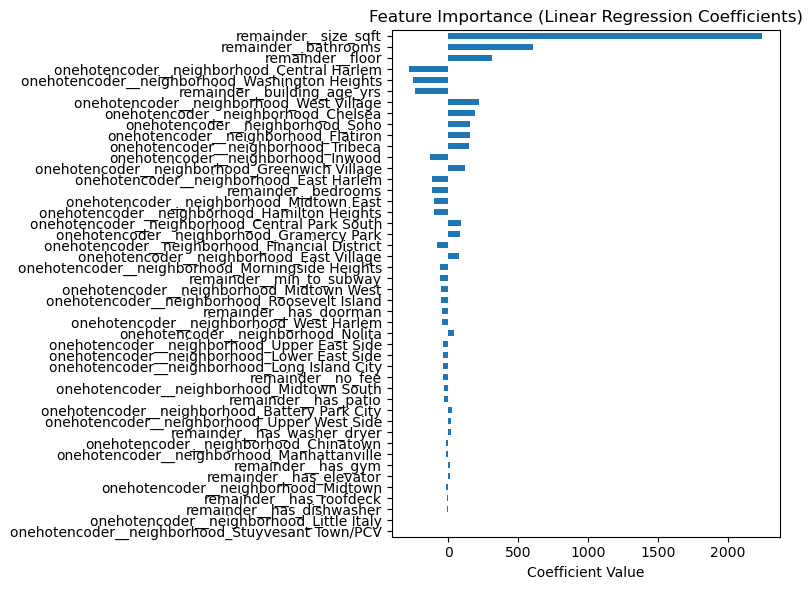

In [37]:
coefficients = pd.Series(model.coef_, index=X_dev_encoded.columns)
coefficients = coefficients.sort_values(key=abs, ascending=True)

# Plot
plt.figure(figsize=(8, 6))
coefficients.plot(kind='barh')
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

In [38]:
#Ridge Regression
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)
model.fit(X_dev_scaled, y_dev)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

Mean Absolute Error (MAE): 860.0198336598986
R² Score: 0.7792809632015609


In [39]:
#Lasso Regression
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)
model.fit(X_dev_scaled, y_dev)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

Mean Absolute Error (MAE): 860.0263499365666
R² Score: 0.7792306282559697


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.420e+06, tolerance: 2.871e+06
  model = cd_fast.enet_coordinate_descent(


**The prediction result we get from using simple regression is very inaccurate**

# Random Forest #

In [42]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_dev_scaled, y_dev)

y_pred = rf.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

Mean Absolute Error: 717.388198984396
R^2 Score: 0.8107340167738416


In [43]:
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
ohe_features = cat_features_hot
preprocess = make_column_transformer(
	(StandardScaler(), numerical_features),
	(OneHotEncoder(handle_unknown="error"), ohe_features),
	remainder="passthrough")

In [44]:
param_grid = {
	'n_estimators': [100, 200, 300],
	'max_depth': [None, 10, 20, 30],
	'min_samples_split': [2, 5, 10],
	'min_samples_leaf': [1, 2, 4]
}

## YOUR CODE HERE
pipe_tune_rf = make_pipeline(preprocess,
							 GridSearchCV(rf,
									  param_grid=param_grid,
									  cv=5,
									  scoring="neg_mean_absolute_error",
									  n_jobs=-1,
									  error_score='raise')
							 )


pipe_tune_rf.fit(X_dev_gs, y_dev)
best_params = pipe_tune_rf.named_steps['gridsearchcv'].best_params_

In [45]:
# Best parameter combination
print("Best params:", best_params)

# Best CV score (will be negative MAE)
print("Best CV score (neg MAE):", pipe_tune_rf.named_steps['gridsearchcv'].best_score_)

# Convert to positive MAE
print("Best CV MAE:", -pipe_tune_rf.named_steps['gridsearchcv'].best_score_)

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score (neg MAE): -726.4594362064283
Best CV MAE: 726.4594362064283


In [46]:
pipe_rf = make_pipeline(preprocess, RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42))

pipe_rf.fit(X_dev_gs, y_dev)

y_dev_pred = pipe_rf.predict(X_dev_gs)
y_test_pred = pipe_rf.predict(X_test)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test Mean Absolute Error: {test_mae}")
print("Test R^2 Score:", test_r2)

Test Mean Absolute Error: 708.7125064642931
Test R^2 Score: 0.8140284480575632


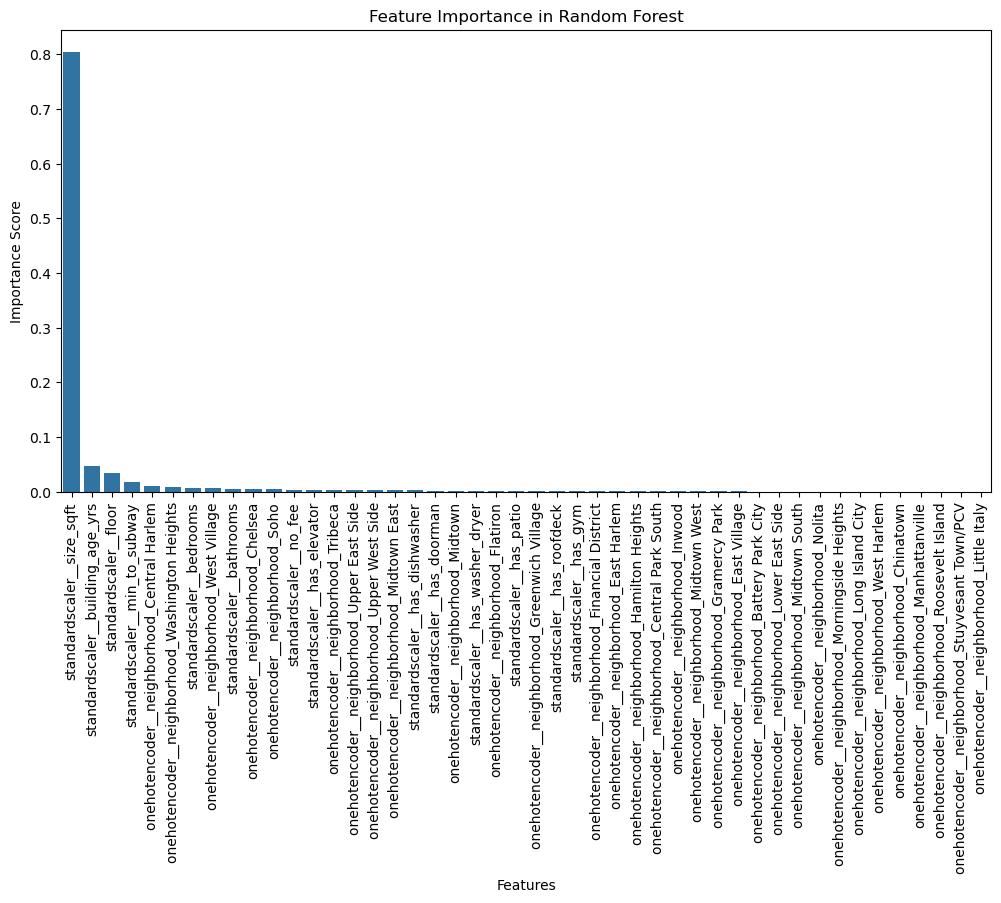

In [47]:
## YOUR CODE HERE
best_rf = pipe_rf.named_steps["randomforestregressor"]
feature_names = pipe_rf.named_steps["columntransformer"].get_feature_names_out()
feat_imps = zip(feature_names, best_rf.feature_importances_)

feats, imps = zip(
    *sorted(
        list(filter(lambda x: x[1] != 0, feat_imps)),
        key=lambda x: x[1],
        reverse=True
    )
)

# Plot feature importance
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(feats), y=list(imps))
ax.set_title("Feature Importance in Random Forest")
ax.set_xlabel("Features")
ax.set_ylabel("Importance Score")
ax.tick_params(axis="x", rotation=90)

plt.show()


# Gradient Boosting for regression¶

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

# Define hyperparameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
pipe_tune_gb = make_pipeline(
    preprocess,
    GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid=param_grid_gb,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        error_score='raise'
    )
)
pipe_tune_gb.fit(X_dev_gs, y_dev)

# Extract the best parameters and CV score from the grid search
best_params_gb = pipe_tune_gb.named_steps['gridsearchcv'].best_params_
print("Best parameters for Gradient Boosting:", best_params_gb)
print("Best CV score (neg MAE):", pipe_tune_gb.named_steps['gridsearchcv'].best_score_)
print("Best CV MAE:", -pipe_tune_gb.named_steps['gridsearchcv'].best_score_)

pipe_gb = make_pipeline(
    preprocess,
    GradientBoostingRegressor(
        n_estimators=best_params_gb['n_estimators'],
        max_depth=best_params_gb['max_depth'],
        learning_rate=best_params_gb['learning_rate'],
        min_samples_split=best_params_gb['min_samples_split'],
        min_samples_leaf=best_params_gb['min_samples_leaf'],
        random_state=42
    )
)

pipe_gb.fit(X_dev_gs, y_dev)
y_dev_pred_gb = pipe_gb.predict(X_dev_gs)
y_test_pred_gb = pipe_gb.predict(X_test)

# Evaluate performance on the test set
test_mae_gb = mean_absolute_error(y_test, y_test_pred_gb)
test_r2_gb = r2_score(y_test, y_test_pred_gb)
test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
print(f"Gradient Boosting Test MAE: {test_mae_gb}")
print(f"Gradient Boosting Test R²: {test_r2_gb}")
print(f"Gradient Boosting Test RMSE: {test_rmse_gb}")

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best CV score (neg MAE): -671.456623000493
Best CV MAE: 671.456623000493
Gradient Boosting Test MAE: 685.526174635731
Gradient Boosting Test R²: 0.8316270035174086
Gradient Boosting Test RMSE: 1260.208083933697


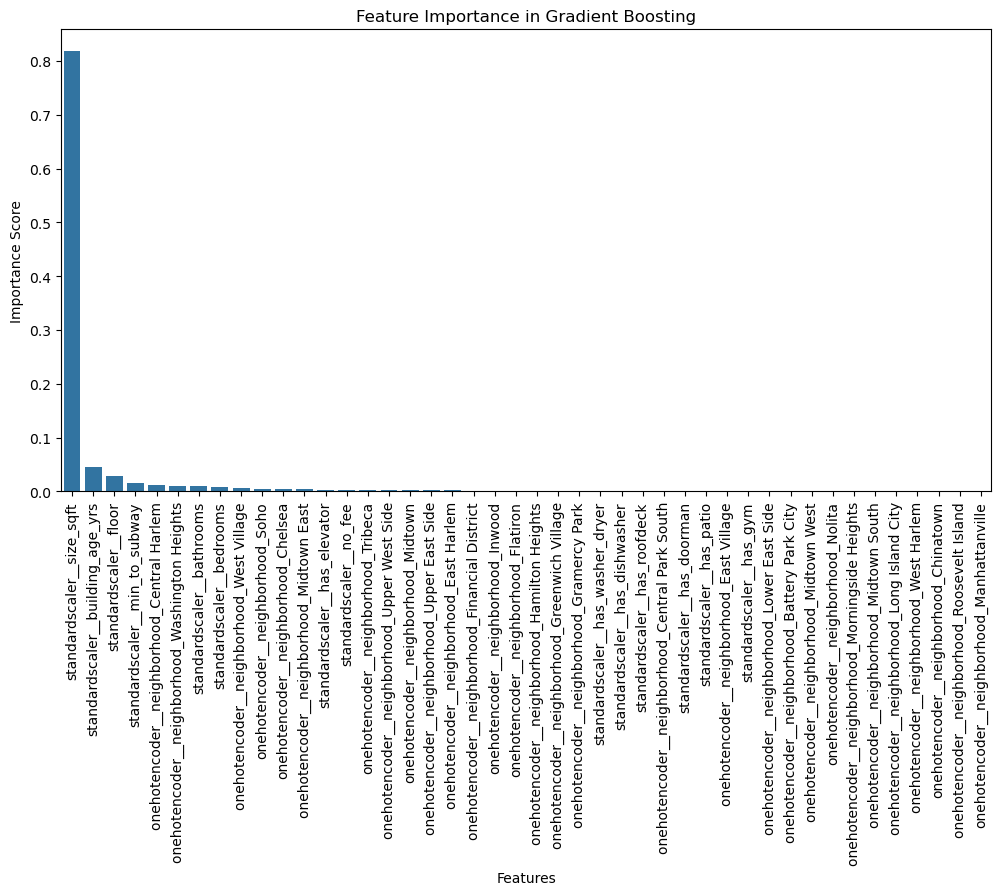

In [50]:
# Analyze feature importances
best_gb_model = pipe_gb.named_steps["gradientboostingregressor"]
feature_names_gb = pipe_gb.named_steps["columntransformer"].get_feature_names_out()
feat_imps_gb = zip(feature_names_gb, best_gb_model.feature_importances_)
feats_gb, imps_gb = zip(
    *sorted(
        list(filter(lambda x: x[1] != 0, feat_imps_gb)),
        key=lambda x: x[1],
        reverse=True
    )
)
# Plot the feature importances
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(feats_gb), y=list(imps_gb))
ax.set_title("Feature Importance in Gradient Boosting")
ax.set_xlabel("Features")
ax.set_ylabel("Importance Score")
ax.tick_params(axis="x", rotation=90)
plt.savefig("gradient_boosting_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

The top 5 most important features identified by gradient boosting model are size_sqft, building_age_yrs, floor, min_to_subway, and neighborhood_central_harlem. Three features (size_sqft, floor, and neighborhood_central_harlem) appear in the top 5 of both the gradient boosting model and the linear regression model, suggesting these variables consistently play a critical role in predicting rent. The plot shows that size_sqft has an importance score close to 1, far exceeding the others. This means that it explains the largest share of the variance in the predictions, making it the most influential factor among those considered

In [254]:
df = pd.read_csv('../data/manhattan.csv')
df.head()

,rental_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood,borough
0,1545,2550,0.0,1,480,9,2.0,17,1,1,0,0,1,1,0,1,Upper East Side,Manhattan
1,2472,11500,2.0,2,2000,4,1.0,96,0,0,0,0,0,0,0,0,Greenwich Village,Manhattan
2,2919,4500,1.0,1,916,2,51.0,29,0,1,0,1,1,1,0,0,Midtown,Manhattan
3,2790,4795,1.0,1,975,3,8.0,31,0,0,0,1,1,1,0,1,Greenwich Village,Manhattan
4,3946,17500,2.0,2,4800,3,4.0,136,0,0,0,1,1,1,0,1,Soho,Manhattan


In [256]:
# Save original size
original_size = df.shape[0]

# IQR-based filtering
Q1 = df['rent'].quantile(0.25)
Q3 = df['rent'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['rent'] >= lower_bound) & (df['rent'] <= upper_bound)]

# Size after filtering
filtered_size = df.shape[0]

print(f"Original dataset size: {original_size}")
print(f"Filtered dataset size: {filtered_size}")
print(f"Removed {original_size - filtered_size} rows ({100 * (original_size - filtered_size) / original_size:.2f}%)")


Original dataset size: 3539
Filtered dataset size: 3266
Removed 273 rows (7.71%)


In [258]:
from scipy.stats import trim_mean

trimmed_means = df.groupby('neighborhood')['rent'].apply(lambda x: trim_mean(x, 0.1))
df['neighborhood_encoded'] = df['neighborhood'].map(trimmed_means)
df = df.drop(columns=['neighborhood'])
df = df.drop(columns=['borough'])
df.head()

,rental_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood_encoded
0,1545,2550,0.0,1,480,9,2.0,17,1,1,0,0,1,1,0,1,4153.687500
2,2919,4500,1.0,1,916,2,51.0,29,0,1,0,1,1,1,0,0,4833.662791
3,2790,4795,1.0,1,975,3,8.0,31,0,0,0,1,1,1,0,1,4364.979592
5,10817,3800,3.0,2,1100,3,5.0,101,0,0,0,0,0,0,0,0,2752.439394
6,9077,1995,0.0,0,600,6,1.0,115,0,0,0,0,0,0,0,0,4021.787535


In [260]:
# 1. Separate features and target
X = df.drop(columns=['rent'])
y = df['rent']

# 2. Create rent bins for stratification (e.g., 5 quantiles)
rent_bins = pd.qcut(y, q=5, labels=False)

# 3. Stratified train/test split using rent bins
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=rent_bins,
    random_state=42
)

# 4. Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 5. Train regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
relative_mae = mae / y_test.mean()

print(f"MAE: ${mae:.2f}")
print(f"Relative MAE: {relative_mae:.2%}")

MAE: $591.21
Relative MAE: 13.36%
